# Import modules and parameters

In [ ]:
!f2py3.10 -c -m fortran_chatgpt ../models/fortran_chatgpt.f90
!f2py3.10 -c -m fortran_integral ../models/fortran_integral.f90
!f2py3.10 -c -m fortran_quad ../models/fortran_quad.f90

In [1]:
#!/usr/bin/pythonpy
################################################################################
# PYTHON's MODULAE
# ------------------------------------------------------------------------------
################################################################################
import os
import sys
module_path = os.path.abspath(os.path.join('/lib/python3.8/site-packages'))
if module_path not in sys.path:
    sys.path.append(module_path)

import fortran_integral
import fortran_quad
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colorbar as colorb
import pickle 
import datetime
from matplotlib import colors

# Total cross sections
import models.sigma0_xsections as sig0
import models.general_parameters as gp
import models.relic_density_calc as ohm
import models.radiative_factorization as hp
import models.pdf_integration as qcd
import lhapdf  

#################################################
today = datetime.date.today().strftime('%Y-%m-%d')

## Some configurations
sigmaz = {}
## Geral parameters
brn = gp.brn
gr0 = gp.gr0
gl0 = gp.gl0
grx0 = gp.grx0 
glx0 = gp.glx0
gx0 = gp.gx0

dmnames = sig0.dmnames
smax = gp.smax
me = gp.mvec[0]

Mmed = gp.Mmed  # TeV
mx  = gp.mx #  0.80 * Mmed/2  DM mass [TeV]
Nf_ee = gp.Nf_ee 
Nf_qq = gp.Nf_qq


---
---
# $e^{+}e^{-}$ interaction

## Relic Density plot

In [33]:
### Larger values will increase the processing time
binsize_ohm = 70
Nfermions = 6
omega_file = open(f'../myruns/omegarelic_mass_ee_bin{binsize_ohm}_nfermions{Nfermions}.pkl', 'rb')
omegarelic_mass_old = pickle.load(omega_file)
omega_file.close()

binsize_ohm = 70
dM = 1/binsize_ohm 
dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.0001
Mmed_max = 5.0
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.0001
mx_max = 2.501
mx_arr = np.arange(mx_min, mx_max, dmx)

# Define a grid
Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

lst = ['Vector']
print('Doing mass x mass...')
omegarelic_mass = {}

for fignumber, dmname in enumerate(sig0.dmnames):


    print(f'Doing {dmname}')
    param_lst = [Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gr0, gl0, gx0, dmname, gp.Nf_ee]
    omegarelic_mass[f'{dmname}'] = {}
    
    if dmname == 'Vector':
        omegarelic_mass[f'{dmname}']['data'] = ohm.Ohm_numerical(Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gr0, gl0, gx0, dmname, gp.Nf_ee)
    else: 
        omegarelic_mass[f'{dmname}']['data'] = omegarelic_mass_old[f'{dmname}']

    omegarelic_mass[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    # saves the computed data for that DM scenario
    gp.save_obj(omegarelic_mass[f'{dmname}'], f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')

#gp.save_obj(omegarelic_mass, f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')

Doing mass x mass...
Doing Scalar
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Scalar_binsize_70.pkl
Done for Scalar
Doing Fermion
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Fermion_binsize_70.pkl
Done for Fermion
Doing Vector
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_ee_Vector_binsize_70.pkl
Done for Vector


Pasta 2023-10-18 já existe.


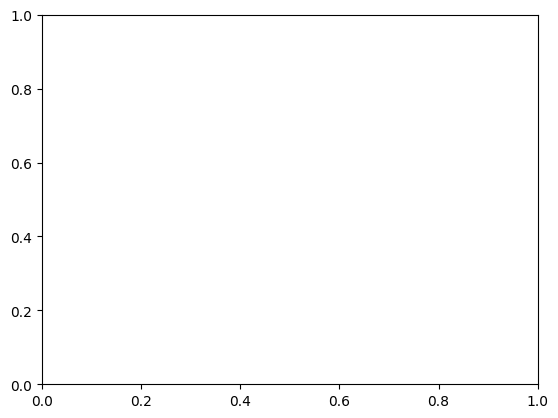

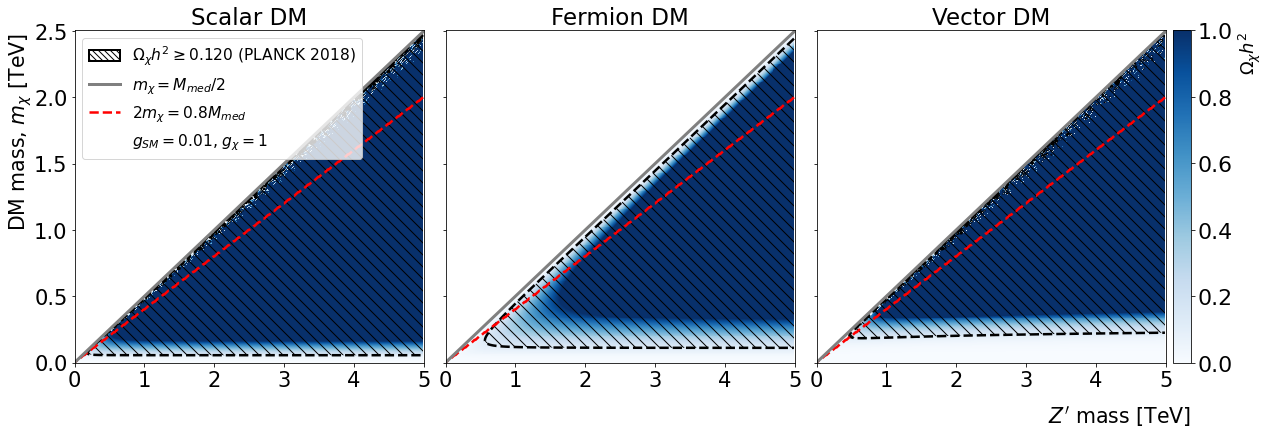

In [25]:

# Verificar se a pasta já existe
if not os.path.exists(f'../figures/{today}'):
    # Se não existir, cria a pasta com a data de hoje
    os.makedirs(f'../figures/{today}')
    print(f'Pasta {today} criada com sucesso.')
else:
    print(f'Pasta {today} já existe.')


fig, ax = plt.subplots()
auxLabel = 'oficial'

for fignumber, dmname in enumerate(sig0.dmnames):
    
    
    #binsize_ohm  = 10 if dmname == 'Vector' else 70
    
    smax = 3**2


    dM = 1/binsize_ohm 
    dmx = 0.5/binsize_ohm 
    #Mediator mass [Tev] # 
    Mmed_min = 0.0001
    Mmed_max = 5.0
    Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

    # DM particle mass [Tev] #
    mx_min = 0.0001
    mx_max = 2.501
    mx_arr = np.arange(mx_min, mx_max, dmx)

    # Define a grid
    Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot
    
    
    # Set up figure and image grid  
    if fignumber == 0:
        fig = plt.figure(figsize=(20, 6))
        ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                nrows_ncols=(1,3),
                axes_pad=(0.30, 0.0),
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.10,
                aspect=False
                )
        fsize = 18


    im = ax[fignumber].pcolormesh(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], vmax=1, vmin=0, cmap='Blues') ##sessão de choque convertida para fb

    ax[fignumber].cax.cla()
    cb = colorb.Colorbar(ax[fignumber].cax, im, )
    ax[fignumber].cax.toggle_label(True)
    cb.set_label(r'$\Omega_{\chi} h^2 $', fontsize = fsize, loc='top')  ## color bar label 
    cb.ax.tick_params(labelsize=fsize+4)

    @np.vectorize
    def contorno_090(Mmed, mx):
        if (2*mx <= (0.8 * Mmed)): 
            res = 1
        else:
            res = 0.001

        return res
    countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata1, colors='k', linewidths=2.5, linestyles='dashed')

    #countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), ohm.planckdata1, colors='red', linewidths=2.5, linestyles='dashed')
    labelOHM = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)'

    # M/2 line #
    x1, y1 = [Mmed_arr[0],Mmed_arr[-1]], [Mmed_arr[0]/2, Mmed_arr[-1]/2]
    ab, = ax[fignumber].plot(x1, y1, linewidth=3, color='grey', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')
    textstr = '\n'.join((
        r'$g_{SM} = %1.2f$, $g_{\chi} = %1.0f$' %(gp.gr0, gp.gx0),
        ))
    

    

    ## Plot Labels ##
    if fignumber == 0:
        ab, = plt.plot(x1, y1, linewidth=3, color='gray', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')
        ad, = plt.plot(0, 0, linewidth=2.5, color='red', linestyle='dashed', label=r'$2{m_\chi } = 0.8{M_{med} }$')
        ac, = plt.plot([], [], label=textstr, color = 'None')
        ax[fignumber].tick_params(axis="y", labelsize=fsize+3)


    ax[fignumber].set_title(f'{dmname} DM', fontsize = fsize+5)

    ax[fignumber].tick_params(axis="x", labelsize=fsize+3)

    
    
    ax[fignumber].set_xlim(0, 5.0) ## plot 'resolution'
    ### FORMAÇÃO DA LEGENDA (PERFEITA)
    #plt.subplots_adjust(right=0.76)
    artists1, labels1 = countour_relic.legend_elements()
    labels1[0] = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)' 
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    artists1.extend(current_handles)
    labels1.extend(current_labels)
    artists1[0]._hatch = "\\\\\\\ "
    #artists1[0].xy = [x00, y00]
    artists1[0]._linestyle = 'dashed'
    artists1[0]._dashes = True
    artists1[0]._linewidth = 2.0
    artists1[0]._edgecolor = (0.0, 0.0, 0.0, 1.0)

    LEG =  ax[0].legend(artists1, labels1, loc='upper left', fontsize = fsize-2.5)


    #get the extent of the largest box containing all the axes/subplots
    if fignumber == 2:
        extents = np.array([a.get_position().extents for a in ax])  #all axes extents
        bigextents = np.empty(4)   
        bigextents[:2] = extents[:,:2].min(axis=0)
        bigextents[2:] = extents[:,2:].max(axis=0)

        #text to mimic the x and y label. The text is positioned in the middle 
        labelpad=0.02  #distance between the external axis and the text
        xlab_t = fig.text(bigextents[2], bigextents[1]-0.15, r'$Z^{\prime}$ mass [TeV]',
            horizontalalignment='right', verticalalignment = 'bottom', size = fsize+2.5)
        ylab_t = fig.text( bigextents[0]*0.7, bigextents[0]*7, r'DM mass, $m_{\chi}$ [TeV]',
            rotation='vertical', horizontalalignment = 'center', verticalalignment = 'top', size = fsize+2.5)

    if fignumber == 2:
        
        #fig.tight_layout()
        #plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
        fig.set_dpi(72)
        fig.savefig(f'../figures/{today}/omega_relic_ee_blue_plot.pdf', dpi=72, bbox_inches = "tight")
            
        ## Plot Labels ##
        plt.title(r''+dmname+' DM production, $e^{+} e^{-} \to Z^{\prime} \to \chi \bar \chi$ '+auxLabel +'', fontsize = 20, loc = 'right')
        plt.xlabel(r'$Z^{\prime}$ mass, $\sqrt{\hat s} = M_{med}$ [TeV]', fontsize = 20, loc = 'right')
        plt.ylabel(r'DM mass, $m_{\chi}$ [TeV] ', fontsize = 20, loc='top')
        #plt.tick_params(axis="x", labelsize=20)
        #plt.tick_params(axis="y", labelsize=20)





## Mass x Mass plot

In [2]:
# # ### Larger values will increase the processing time
# # ###################################################
# # ###################################################
binsize = 70
# # ###################################################
# # ###################################################

# dM = 1/binsize
# dmx = 0.5/binsize

# #Mediator mass [Tev] # 
# smax = 3**2
# Mmed_min = 0.001
# Mmed_max = 5.1
# Mmed = np.arange(Mmed_min, Mmed_max, dM)

# # DM particle mass [Tev] #
# mx_min = 0.001
# mx_max = 2.60
# mx = np.arange(mx_min, mx_max, dmx)

# # Define a grid
# Mmed_grid, mx_grid = np.meshgrid(Mmed, mx) # grid formation for plot

# Read the previous saved file
sigmaz_file = open(f'../myruns/sigmaz_ee_mass_ISR_bin70_Nfermions6_v4.pkl', 'rb')
sigmaz = pickle.load(sigmaz_file)
sigmaz_file.close()
# ### Larger values will increase the processing time
# ###################################################
# ###################################################
binsize = 100
# ###################################################
###################################################

dM = 1/binsize
dmx = 0.5/binsize

#Mediator mass [Tev] # 
smax = 3**2
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.001
mx_max = 2.60
mx_arr = np.arange(mx_min, mx_max, dmx)

# # Define a grid
# Mmed_grid, mx_grid = np.meshgrid(Mmed, mx) # grid formation for plot

# ## ADD New VECTOR PART 

# dmnames = ['Vector']
# for fignumber, dmname in enumerate(dmnames):

#     #HPhsig(s, mq, Mmed, mx, gr, gl, gx, sig0)

#     sigmaz[f'{dmname}'] = hp.HPhsig(smax, me, Mmed_grid, mx_grid, gr0, gl0, gx0, sig0.SFV(dmname).sig0) 
#     #sigmaz[f'{dmname}'] = SFV(dmname).sig0(smax, mvec[0], Mmed_grid, mx_grid, gr0, gl0, gx0)
#     print(f'Done for {dmname} DM.')


# # sigmaz_file = open(f'myruns/sigmaz_ee_mass_ISR_bin{binsize}_Nfermions{Nfermions}_v3.pkl', 'wb')
# # pickle.dump(sigmaz, sigmaz_file)
# # sigmaz_file.close()

binsize_ohm = 70
omega_file = open(f'../myruns/omegarelic_mass_ee_bin70_nfermions6.pkl', 'rb')
omegarelic_mass = pickle.load(omega_file)

dM = 1/binsize_ohm 
dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.0001
Mmed_max = 5.0
Mmed_ohm = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.0001
mx_max = 2.501
mx_ohm = np.arange(mx_min, mx_max, dmx)

doing Scalar
doing Fermion
doing Vector


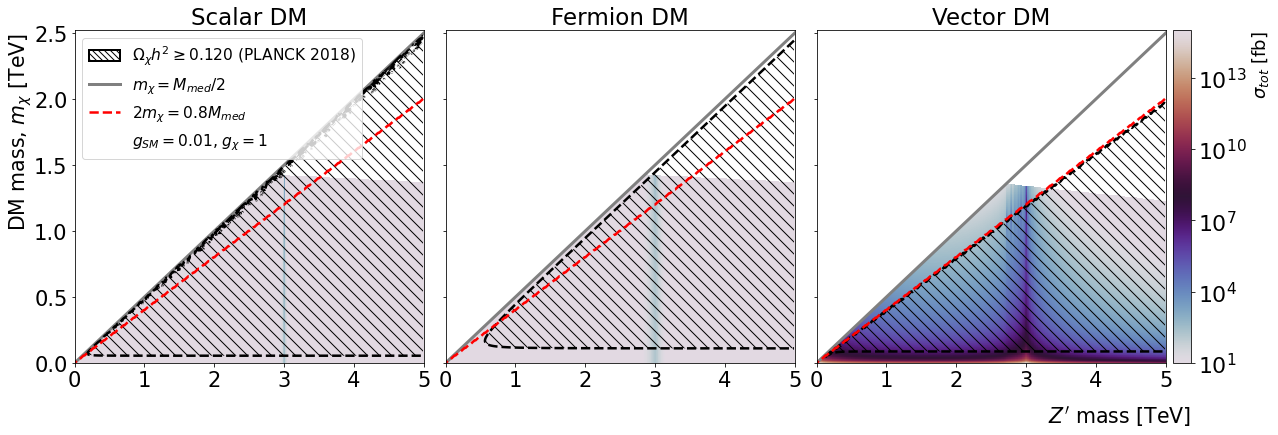

In [3]:
import utils.colorb_2D as cb2d

cb2d.cb_plot3x1('mass_ee_ISR', sigmaz, Mmed_arr, mx_arr, omegarelic_mass, Mmed_ohm, mx_ohm, sig0.dmnames, gp.gr0,
               cmap = 'twilight', fsize = 18, folder = '../figures')

In [30]:
gp.save_obj(sigmaz, f'../myruns/sigmaz_ee_mass_ISR_bin{binsize}_Nfermions{Nf_ee}_v4.pkl')

Objeto salvo em ../myruns/sigmaz_ee_mass_ISR_bin70_Nfermions6_v4.pkl


In [17]:
sigmaz = gp.load_obj(f'../myruns/sigmaz_ee_mass_ISR_bin70_Nfermions{Nf_ee}_v4.pkl')

# $q \bar q$ interaction 


## Relic Density plot

In [34]:
### Larger values will increase the processing time
# omega_file = open(f'../myruns/omegarelic_mass_qq_bin{binsize}_nfermions{Nf_qq}.pkl', 'rb')
# omegarelic_mass_old = pickle.load(omega_file)
# omega_file.close()

binsize_ohm = 70
dM = 1/binsize_ohm 
dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.0001
Mmed_max = 5.0
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.0001
mx_max = 2.501
mx_arr = np.arange(mx_min, mx_max, dmx)

# Define a grid
Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

print('Doing mass x mass...')
omegarelic_mass = {}

for fignumber, dmname in enumerate(sig0.dmnames):


    print(f'Doing {dmname}')
    param_lst = [Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gp.gr0_q, gp.gr0_q, gx0, dmname, gp.Nf_qq]
    omegarelic_mass[f'{dmname}'] = {}
    
    #if dmname == 'Vector':
    omegarelic_mass[f'{dmname}']['data'] = ohm.Ohm_numerical(Mmed_grid_ohm**2, me, Mmed_grid_ohm, mx_grid_ohm, gp.gr0_q, gp.gr0_q, gx0, dmname, gp.Nf_qq)
    #else: 
    #    omegarelic_mass[f'{dmname}']['data'] = omegarelic_mass_old[f'{dmname}']

    omegarelic_mass[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
    # saves the computed data for that DM scenario
    gp.save_obj(omegarelic_mass[f'{dmname}'], f'../myruns/{today}_omegarelic_mass_qq_{dmname}_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')

#gp.save_obj(omegarelic_mass, f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')

Doing mass x mass...
Doing Scalar
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Scalar_binsize_70.pkl
Done for Scalar
Doing Fermion
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Fermion_binsize_70.pkl
Done for Fermion
Doing Vector
Objeto salvo em ../myruns/2023-10-23_omegarelic_mass_qq_Vector_binsize_70.pkl
Done for Vector


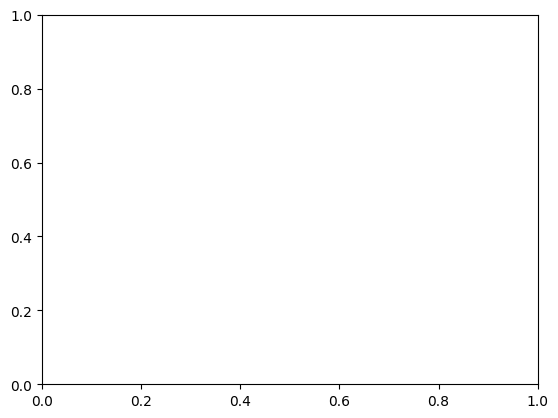

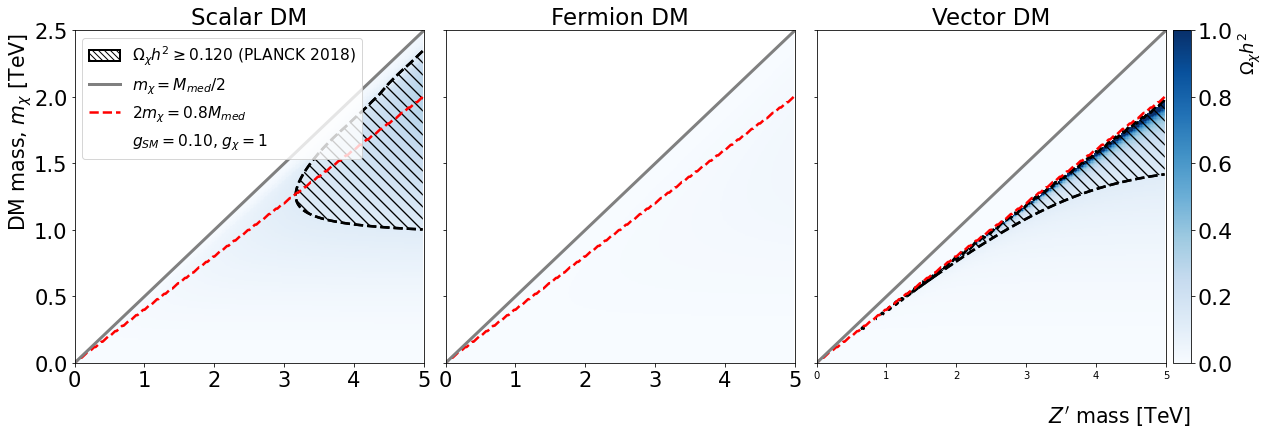

In [13]:
## Bin resolution of the calculation, bigger numbers increases the computation time considerably(!)
binsize = 50
Nfermions = 18

dM = 1/binsize
dmx = 0.5/binsize
#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.0
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.001
mx_max = 2.501
mx_arr = np.arange(mx_min, mx_max, dmx)


# Define a grid
Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

## To make changes on the plot, execute from this line below

omega_file = open(f'../myruns/omegarelic_mass_qq_bin{binsize}_nfermions{Nfermions}.pkl', 'rb')
omegarelic_mass = pickle.load(omega_file)
omega_file.close()


fig, ax = plt.subplots()


auxLabel = 'oficial'
for fignumber, dmname in enumerate(sig0.dmnames):
    

    auxLabel = auxLabel
    
    
    # Set up figure and image grid  
    if fignumber == 0:
        fig = plt.figure(figsize=(20, 6))
        ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                nrows_ncols=(1,3),
                axes_pad=(0.30, 0.0),
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.10,
                aspect=False
                )
        fsize = 18

    ax[fignumber].set_ylim(0, 2.50) ## plot 'resolution'

    im = ax[fignumber].pcolormesh(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], vmax=1, vmin=0, cmap='Blues') ##sessão de choque convertida para fb

    # Colorbar
    ax[fignumber].cax.cla()
    cb = colorb.Colorbar(ax[fignumber].cax, im, )
    ax[fignumber].cax.toggle_label(True)
    cb.set_label(r'$\Omega_{\chi} h^2 $', fontsize = fsize, loc='top')  ## color bar label 
    cb.ax.tick_params(labelsize=fsize+4)


    countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata1, colors='k', linewidths=2.5, linestyles='dashed')
    labelOHM = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)'
    #ax[fignumber].axvline(x = 2.0, color='lightskyblue', linestyle='--', label='CMS/ATLAS')
    countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata1, colors='k', linewidths=2.5, linestyles='dashed')

    @np.vectorize
    def contorno_090(Mmed, mx):
        if (2*mx <= (0.8 * Mmed)): 
            res = 1
        else:
            res = 0.001

        return res


    #countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), ohm.planckdata1, colors='red', linewidths=2.5, linestyles='dashed')
    labelOHM = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)'

    # M/2 line #
    x1, y1 = [Mmed_arr[0],Mmed_arr[-1]], [Mmed_arr[0]/2, Mmed_arr[-1]/2]
    ab, = ax[fignumber].plot(x1, y1, linewidth=3, color='grey', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')
    textstr = '\n'.join((
        r'$g_{SM} = %1.2f$, $g_{\chi} = %1.0f$' %(gp.gr0_q, gp.gx0),
        ))

    ## Plot Labels ##
    if fignumber == 0:
        ab, = plt.plot(x1, y1, linewidth=3, color='gray', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')
        ad, = plt.plot(0, 0, linewidth=2.5, color='red', linestyle='dashed', label=r'$2{m_\chi } = 0.8{M_{med} }$')
        ac, = plt.plot([], [], label=textstr, color = 'None')


    ax[fignumber].set_title(f'{dmname} DM', fontsize = fsize+5)

    ax[0].tick_params(axis="x", labelsize=fsize+3)
    ax[1].tick_params(axis="x", labelsize=fsize+3)
    #ax[2].tick_params(axis="x", labelsize=fsize+3)
    ax[0].tick_params(axis="y", labelsize=fsize+3)
    
    ### FORMAÇÃO DA LEGENDA (PERFEITA)
    #plt.subplots_adjust(right=0.76)
    ax[fignumber].set_xlim(0, 5.0) ## plot 'resolution'
    artists1, labels1 = countour_relic.legend_elements()
    labels1[0] = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)' 
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    artists1.extend(current_handles)
    labels1.extend(current_labels)
    artists1[0]._hatch = "\\\\\\\ "
    #artists1[0].xy = [x00, y00]
    artists1[0]._linestyle = 'dashed'
    artists1[0]._dashes = True
    artists1[0]._linewidth = 2.0
    artists1[0]._edgecolor = (0.0, 0.0, 0.0, 1.0)

    LEG =  ax[0].legend(artists1, labels1, loc='upper left', fontsize = fsize-2.5)


    #get the extent of the largest box containing all the axes/subplots
    if fignumber == 2:
        extents = np.array([a.get_position().extents for a in ax])  #all axes extents
        bigextents = np.empty(4)   
        bigextents[:2] = extents[:,:2].min(axis=0)
        bigextents[2:] = extents[:,2:].max(axis=0)

        #text to mimic the x and y label. The text is positioned in the middle 
        labelpad=0.02  #distance between the external axis and the text
        xlab_t = fig.text(bigextents[2], bigextents[1]-0.15, r'$Z^{\prime}$ mass [TeV]',
            horizontalalignment='right', verticalalignment = 'bottom', size = fsize+2.5)
        ylab_t = fig.text( bigextents[0]*0.7, bigextents[0]*7, r'DM mass, $m_{\chi}$ [TeV]',
            rotation='vertical', horizontalalignment = 'center', verticalalignment = 'top', size = fsize+2.5)

    if fignumber == 2:
        
        #fig.tight_layout()
        #plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
        fig.set_dpi(72)
        fig.savefig(f'../figures/{today}/omega_relic_qq_blue_plot.pdf', dpi=72, bbox_inches = "tight")
            
        ## Plot Labels ##
        #plt.title(r''+dmname+' DM production, $e^{+} e^{-} \to Z^{\prime} \to \chi \bar \chi$ '+auxLabel +'', fontsize = 20, loc = 'right')
        #plt.xlabel(r'$Z^{\prime}$ mass, $\sqrt{\hat s} = M_{med}$ [TeV]', fontsize = 20, loc = 'right')
        #plt.ylabel(r'DM mass, $m_{\chi}$ [TeV] ', fontsize = 20, loc='top')
        #plt.tick_params(axis="x", labelsize=20)
        #plt.tick_params(axis="y", labelsize=20)





In [41]:
binsize = 100
dM = 1/binsize
dmx = 0.5/binsize

#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

# DM particle mass [Tev] #
mx_min = 0.001
mx_max = 2.60
mx_arr = np.arange(mx_min, mx_max, dmx)

# Define a grid
Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

## CM total energy (14 TeV for HL-LHC)
s_max = (14)**2  
sigmaz_file = open(f'../myruns/sigmaz_qq_mass_ISR_bin100_Nfermions18_v2.pkl', 'rb')
sigmaz = pickle.load(sigmaz_file)
sigmaz_file.close()
sighat_hphoton = {}

print('Doing mass x mass...')

for fignumber, dmname in enumerate(sig0.dmnames):

    #define pdf
    print(f'Doing {dmname}')
    PDF_sets = ['CT10', 'NNPDF31_lo_as_0118', 'CT18NLO', 'MMHT2014lo68cl', 'PDF4LHC15_nlo_100']
    pdf = lhapdf.mkPDF(PDF_sets[1], 0)
    param_lst = [Mmed_grid**2, me, Mmed_grid, mx_grid, gp.gr0_q, gp.gr0_q, gx0, dmname, gp.Nf_qq]

    sigmaz[f'{dmname}'] = {}
    if dmname == 'Vector':
        continue
        sig0funcs = sig0.SFV(dmname).sig0
        sighat_hphoton[f'{dmname}'] = hp.HPhsig(Mmed_grid**2, me, Mmed_grid, mx_grid, gp.gr0_q, gp.gr0_q, gx0, sig0funcs, gp.Nf_qq)

        sigmaz[f'{dmname}']['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed_grid)**2/s_max, Mmed_grid, 1, mx_grid, gp.gr0_q, gp.gr0_q, gx0, sighat_hphoton[f'{dmname}'])
        sigmaz[f'{dmname}']['data'] = np.array(list(sigmaz[f'{dmname}']['data'][:, :]), dtype=np.float)


        sigmaz[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
        gp.save_obj(sigmaz[f'{dmname}'], f'../myruns/{today}_sigmaz_mass_qq_{dmname}_binsize_{binsize}.pkl')
    
    else:
        sigmaz[f'{dmname}']['data'] = sigmaz[f'{dmname}']
        sigmaz[f'{dmname}']['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))
        gp.save_obj(sigmaz[f'{dmname}'], f'../myruns/{today}_sigmaz_mass_qq_{dmname}_binsize_{binsize}.pkl')

#gp.save_obj(omegarelic_mass, f'../myruns/{today}_omegarelic_mass_ee_{dmname}_binsize_{binsize_ohm}.pkl')

Doing mass x mass...
Doing Scalar
LHAPDF 6.5.3 loading /share/LHAPDF/NNPDF31_lo_as_0118/NNPDF31_lo_as_0118_0000.dat
NNPDF31_lo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 315000
Objeto salvo em ../myruns/2023-10-23_sigmaz_mass_qq_Scalar_binsize_100.pkl
Doing Fermion
LHAPDF 6.5.3 loading /share/LHAPDF/NNPDF31_lo_as_0118/NNPDF31_lo_as_0118_0000.dat
NNPDF31_lo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 315000
Objeto salvo em ../myruns/2023-10-23_sigmaz_mass_qq_Fermion_binsize_100.pkl
Doing Vector
LHAPDF 6.5.3 loading /share/LHAPDF/NNPDF31_lo_as_0118/NNPDF31_lo_as_0118_0000.dat
NNPDF31_lo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 315000


In [ ]:
sigmaz

In [12]:
gp.save_obj(sigmaz, f'../myruns/{today}-sigmaz_qq_mass_ISR_bin{binsize}_Nfermions{Nf_qq}_v4.pkl')

Objeto salvo em ../myruns/2023-10-18-sigmaz_qq_mass_ISR_bin100_Nfermions18_v4.pkl


##  Mass x Mass plot

In [43]:
import utils.colorb_2D as cb2d
sigmaz = {}
for dmname in sig0.dmnames:
    sigmaz[dmname]  = gp.load_obj(f'../myruns/{today}_sigmaz_mass_qq_{dmname}_binsize_{binsize}.pkl')

binsize_ohm = 70
omegarelic_mass = {}
for dmname in sig0.dmnames:
    omegarelic_mass[dmname]  = gp.load_obj(f'../myruns/{today}_omegarelic_mass_qq_{dmname}_binsize_{binsize_ohm}.pkl')



In [ ]:
cb2d.cb_plot3x1('mass_qq_ISR', sigmaz, Mmed_arr, mx_arr, omegarelic_mass, Mmed_ohm, mx_ohm, sig0.dmnames, gp.gr0,
               cmap = 'twilight', fsize = 18, folder = '../figures')

Pasta 2023-10-18 já existe.
doing Scalar
doing Fermion
doing Vector


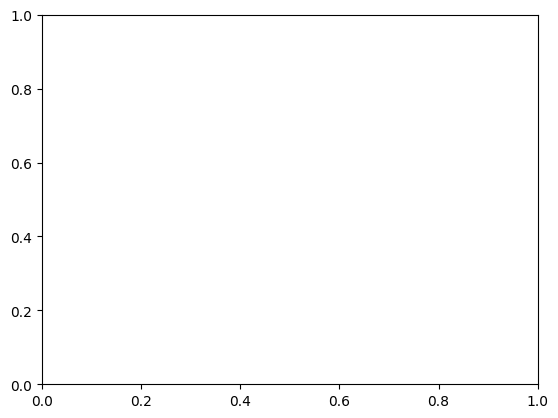

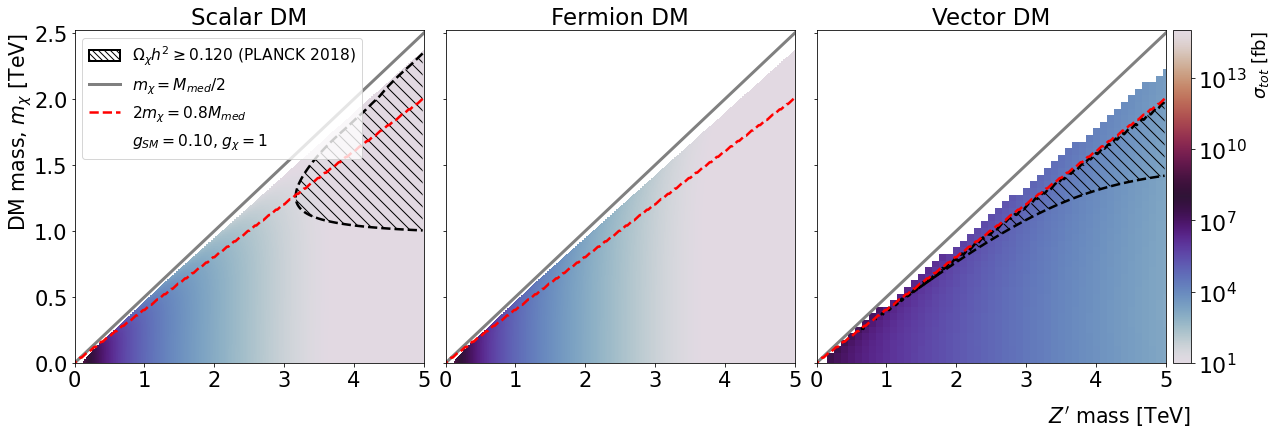

In [10]:
fig, ax = plt.subplots()
today = datetime.date.today().strftime('%Y-%m-%d')
# Verificar se a pasta já existe
if not os.path.exists(f'../figures/{today}'):
    # Se não existir, cria a pasta com a data de hoje
    os.makedirs(f'../figures/{today}')
    print(f'Pasta {today} criada com sucesso.')
else:
    print(f'Pasta {today} já existe.')


auxLabel = 'oficial'
for fignumber, dmname in enumerate(sig0.dmnames):
    print(f'doing {dmname}')

    binsize = 10 if dmname == 'Vector' else 100

    ### Larger values will increase the processing time
    dM = 1/binsize
    dmx = 0.5/binsize

    #Mediator mass [Tev] # 
    Mmed_min = 0.001
    Mmed_max = 5.1
    Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

    # DM particle mass [Tev] #
    mx_min = 0.001
    mx_max = 2.60
    mx_arr = np.arange(mx_min, mx_max, dmx)
    
    Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

    # Set up figure and image grid  
    if fignumber == 0:
        fig = plt.figure(figsize=(20, 6))
        ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                nrows_ncols=(1,3),
                axes_pad=(0.30, 0.0),
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.10,
                aspect=False
                )
        fsize = 18
                    # Colorbar
    
    ## Plot it in a color bar
    im = ax[fignumber].pcolormesh(Mmed_grid, mx_grid, sigmaz[f'{dmname}']*brn, norm=colors.LogNorm(vmin=1E1, vmax=1E15), cmap='twilight', rasterized=True) ## heat map of xsec
    
    
    #ax[fignumber].set_xlim(0, 5.2) ## plot 'resolution'

    ax[0].cax.cla()
    cb = colorb.Colorbar(ax[0].cax, im)
    ax[0].cax.toggle_label(True)
    cb.solids.set_rasterized(True)
    cb.set_label(r'$\sigma_{tot}$ [fb]', fontsize = fsize, loc='top')  ## color bar label 
    cb.ax.tick_params(labelsize=fsize+4)


    # ######################################################################################

        
    # M/2 line #
    x1, y1 = [Mmed[0], Mmed[-1]], [Mmed[0]/2, Mmed[-1]/2]
    ab, = ax[fignumber].plot(x1, y1, linewidth=3, color='grey', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')

    textstr = '\n'.join((
        r'$g_{SM} = %1.2f$, $g_{\chi} = %1.0f$' %(gp.gr0_q, gp.gx0),
        ))
    ax[0].plot([], [], label=textstr, color = 'None')


    ## Plot Labels ##

    #ax[fignumber].axvline(x = 2.0, color='lightskyblue', linestyle='--', label='CMS/ATLAS')
    if fignumber == 0:
        ab, = plt.plot(x1, y1, linewidth=3, color='gray', linestyle='solid', label=r'${m_\chi } = {M_{med} }/2$')
        ac, = plt.plot(0, 0, linewidth=2.5, color='red', linestyle='dashed', label=r'$2{m_\chi } = 0.8{M_{med} }$')
        ad, = plt.plot([], [], label=textstr, color = 'None')
        #ac, = plt.plot([], [],  color='lightskyblue', linestyle='--', label=r'CMS/ATLAS $Z^{\prime}$ limit')
        ax[fignumber].tick_params(axis="y", labelsize=fsize+3)

    ax[fignumber].set_title(f'{dmname} DM', fontsize = fsize+5)

    ax[fignumber].tick_params(axis="x", labelsize=fsize+3)



    ####################### RELIC DENSITY CONTOUR  #######################################
    # ######################################################################################
    binsize_ohm = 50
    ax[fignumber].set_ylim(0, 2.519) ## plot 'resolution'
    omega_file = open(f'../myruns/omegarelic_mass_qq_bin{binsize_ohm}_nfermions{Nf_qq}.pkl', 'rb')
    omegarelic_mass = pickle.load(omega_file)
    omega_file.close()
    
    

    #binsize_ohm = binsize
    dM = 1/binsize_ohm
    dmx = 0.5/binsize_ohm
    #Mediator mass [Tev] # 
    Mmed_min = 0.001
    Mmed_max = 5.0
    Mmed_arr = np.arange(Mmed_min, Mmed_max, dM)

    # DM particle mass [Tev] #
    mx_min = 0.001
    mx_max = 2.501
    mx_arr = np.arange(mx_min, mx_max, dmx)
    # Define a grid
    Mmed_grid_ohm, mx_grid_ohm = np.meshgrid(Mmed_arr, mx_arr) # grid formation for plot

    #ax[fignumber].axvline(x = 2.0, color='lightskyblue', linestyle='--', label='CMS/ATLAS')
    countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata2[0], colors='none', hatches=['\\\\'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, omegarelic_mass[f'{dmname}'], ohm.planckdata1, colors='k', linewidths=2.5, linestyles='dashed')

    @np.vectorize
    def contorno_090(Mmed, mx):
        if (2*mx <= (0.8 * Mmed)): 
            res = 10
        else:
            res = 0.00001

        return res


    #countour_relic = ax[fignumber].contourf(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), planckdata2[0], colors='none', hatches=['+'])
    countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, mx_grid_ohm, contorno_090(Mmed_grid_ohm, mx_grid_ohm), ohm.planckdata1, colors='red', linewidths=2.5, linestyles='dashed')
    labelOHM = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)'


    # ######################################################################################
    # ######################################################################################
    # ######################################################################################
    ax[fignumber].set_xlim(0, 5.0) ## plot 'resolution'

    # # ### FORMAÇÃO DA LEGENDA (PERFEITA)
    #plt.subplots_adjust(right=0.76)
    artists1, labels1 = countour_relic.legend_elements()
    labels1[0] = r'${\Omega _\chi }{h^2} \geq 0.120$ (PLANCK 2018)' 
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    artists1.extend(current_handles)
    labels1.extend(current_labels)
    artists1[0]._hatch = "\\\\\\\ "
    #artists1[0].xy = [x00, y00]
    artists1[0]._linestyle = 'dashed'
    artists1[0]._dashes = True
    artists1[0]._linewidth = 2.0
    artists1[0]._edgecolor = (0.0, 0.0, 0.0, 1.0)
    LEG =  ax[0].legend(artists1, labels1, loc='upper left', fontsize = fsize-2.5)




    #get the extent of the largest box containing all the axes/subplots
    if fignumber == 2:
        extents = np.array([a.get_position().extents for a in ax])  #all axes extents
        bigextents = np.empty(4)   
        bigextents[:2] = extents[:,:2].min(axis=0)
        bigextents[2:] = extents[:,2:].max(axis=0)

        #text to mimic the x and y label. The text is positioned in the middle 
        labelpad=0.02  #distance between the external axis and the text
        xlab_t = fig.text(bigextents[2], bigextents[1]-0.15, r'$Z^{\prime}$ mass [TeV]',
            horizontalalignment='right', verticalalignment = 'bottom', size = fsize+2.5)
        ylab_t = fig.text( bigextents[0]*0.7, bigextents[0]*7, r'DM mass, $m_{\chi}$ [TeV]',
            rotation='vertical', horizontalalignment = 'center', verticalalignment = 'top', size = fsize+2.5)




    if fignumber == 2:
        
        #fig.tight_layout()
        #plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
        fig.set_dpi(72)
        fig.savefig(f'../figures/{today}/mass_qq_ISR.pdf', dpi=72, bbox_inches = "tight")
            
        ## Plot Labels ##
        plt.title(r''+dmname+' DM production, $e^{+} e^{-} \to Z^{\prime} \to \chi \bar \chi$ '+auxLabel +'', fontsize = 20, loc = 'right')
        plt.xlabel(r'$Z^{\prime}$ mass, $\sqrt{\hat s} = M_{med}$ [TeV]', fontsize = 20, loc = 'right')
        plt.ylabel(r'DM mass, $m_{\chi}$ [TeV] ', fontsize = 20, loc='top')
        #plt.tick_params(axis="x", labelsize=20)
        #plt.tick_params(axis="y", labelsize=20)
